## 개요

1. 아래 링크의 Ortools를 활용한 해법을 참고하였습니다.

   https://www.kaggle.com/code/spacelx/2020-hc-dd-2nd-place-solution-w-or-tools

2. 이 코드에서 수치 값이 아닌 인간의 직관이 들어간 부분은 크게 두 부분입니다.

- 무조건 Warehouse에서 출발하면 전부 다 배송하고 나서야만 Warehouse를 방문할 수 있다.
- Priority의 지표를 weight \* distance 값을 이용한다.

3. 이 중 전자를 개선하기에는 다루는 경우의 수가 매우 커지기 때문에 후자를 개선해보기로 하였습니다.
4. 후자의 지표를 개선하기 위해서 EDA를 수행하고, 점수 산정 방식을 분석합니다.
5. 후자의 지표를 개선하는 과정에서 "Priority 지표 선정" 과정과 "드론 배차" 과정에 로직 수정이 존재합니다.
6. 더불어 Ortools의 활용 능력을 기르기 위해, 구현 역시 처음부터 다시 제가 직접 해보았습니다.레퍼런스 코드를 참고하며 구현했습니다.


## Import Modules


In [18]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from ortools.graph.python import min_cost_flow
from collections import Counter
from IPython.display import display
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as mcm
import matplotlib as mpl
import pickle


## Load Data From Input File


In [3]:
with open("./data/busy_day.in") as f:
    lines = f.readlines()
lines = [list(map(int, line.rstrip().split())) for line in lines]
lines[3774]


[385, 258, 15, 40]

In [4]:
ROWS, COLS, DRONE_NUM, TURN_NUM, PAYLOAD = lines[0]
PRODUCT_TYPE_LEN = lines[1][0]
PRODUCT_WEIGHTS = lines[2]
WAREHOUSE_LEN = lines[3][0]
warehouse_info_lines = lines[4:4 + (2 * WAREHOUSE_LEN)]
WAREHOUSE_INFO = []
for i in range(WAREHOUSE_LEN):
    warehouse = {"id": i,
                 "pos_row": warehouse_info_lines[2*i][0],
                 "pos_col": warehouse_info_lines[2*i][1],
                 "stock_list": warehouse_info_lines[2*i + 1]}
    WAREHOUSE_INFO.append(warehouse)
ORDERS_LEN = lines[4 + (2 * WAREHOUSE_LEN)][0]
order_info_lines = lines[-(3 * ORDERS_LEN):]
ORDERS_INFO = []
for i in range(ORDERS_LEN):
    order = {"id": i,
             "pos_row": order_info_lines[3*i][0],
             "pos_col": order_info_lines[3*i][1],
             "ordered_items": order_info_lines[3*i + 2],
             }
    ORDERS_INFO.append(order)
PAYLOAD

200

## Make DataFrames

- **Entities** : product_df, warehouse_df, order_df

### 1. product_df

- fields : id, weight, order_id_list, stock_warehouse_list

### 2. warehouse_df

- fields : id, pos_row, pos_col, stock_list

### 3. orders_df

- fields : id, pos_row, pos_col, ordered_items


from_wh_df

[order][item][stock]


In [5]:
product_df = pd.DataFrame([{"id": idx, "weight": weight, "order_id_list": [], "stock_warehouse_list": []} for idx, weight in enumerate(
    PRODUCT_WEIGHTS)], index=None).set_index("id", inplace=False)
for order in ORDERS_INFO:
    for item in order["ordered_items"]:
        product_df.loc[item, "order_id_list"].append(order["id"])
for warehouse in WAREHOUSE_INFO:
    for item, stock in enumerate(warehouse["stock_list"]):
        if stock > 0:
            product_df.loc[item, "stock_warehouse_list"].append(
                (warehouse["id"], stock))
warehouse_df = pd.DataFrame(WAREHOUSE_INFO).set_index("id", inplace=False)
orders_df = pd.DataFrame(ORDERS_INFO).set_index("id", inplace=False)
orders_df


,pos_row,pos_col,ordered_items
id,,,
0,340,371,"[226, 183, 6, 220, 299, 280, 12, 42]"
1,163,320,[163]
2,201,331,"[192, 81]"
3,257,290,"[270, 305, 111, 37, 219, 111, 96, 290, 377, 113]"
4,115,512,"[169, 146, 397, 263, 342, 275, 18, 26]"
...,...,...,...
1245,138,331,"[328, 48, 114, 69, 114, 273, 328, 164]"
1246,109,273,"[362, 283, 356, 58, 361, 57, 377, 302]"
1247,161,291,"[348, 364, 293, 260, 200, 288, 43, 384, 32, 6,..."


## EDA


### Warehouses and Orders


/var/folders/3_/19vyqy_n009677wdd2xcl_xh0000gn/T/ipykernel_35498/2043782459.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mcm.get_cmap("nipy_spectral")


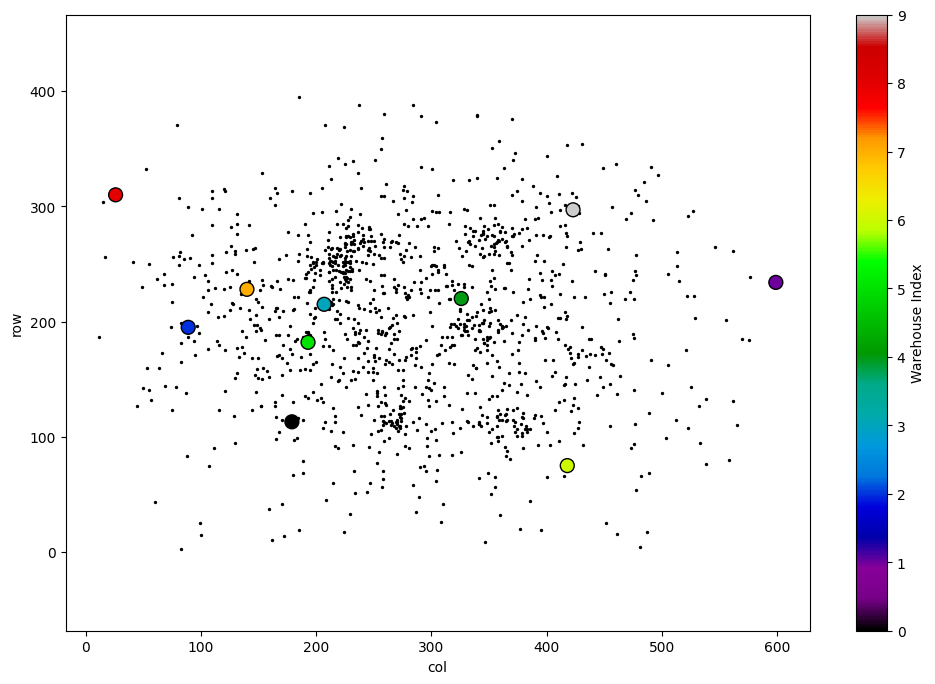

In [6]:
cmap = mcm.get_cmap("nipy_spectral")
wh_colors = [cmap(i) for i in np.linspace(0, 1, num=WAREHOUSE_LEN)]

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(warehouse_df["pos_col"], warehouse_df["pos_row"],
           ec="black", color=wh_colors, s=100, zorder=1)
ax.scatter(orders_df["pos_col"], orders_df["pos_row"],
           color="black", s=2, zorder=0)
ax.set_xlabel("col")
ax.set_ylabel("row")
ax.axis("equal")

norm = mpl.colors.Normalize(vmin=0, vmax=WAREHOUSE_LEN-1)
cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cb.set_label('Warehouse Index')

plt.show()


### Weight Distribution


/opt/homebrew/Caskroom/miniconda/base/envs/kaggle/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


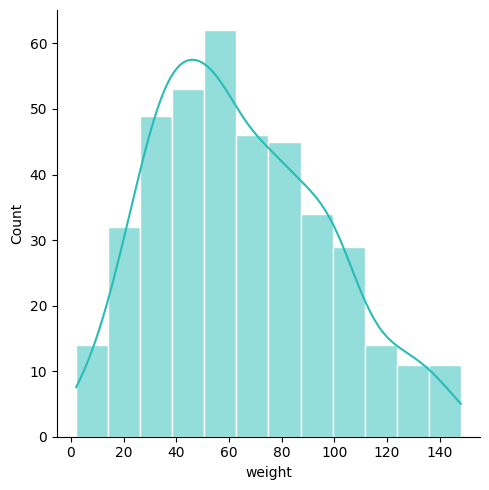

In [7]:
design_setting = {"color": "#29BCB7", "ec": "white"}
weights = product_df.loc[:, "weight"]
sns.displot(weights, kde=True, **design_setting)
plt.show()


### Order 별 weight의 크기와 WareHouse 재고의 Weight 크기


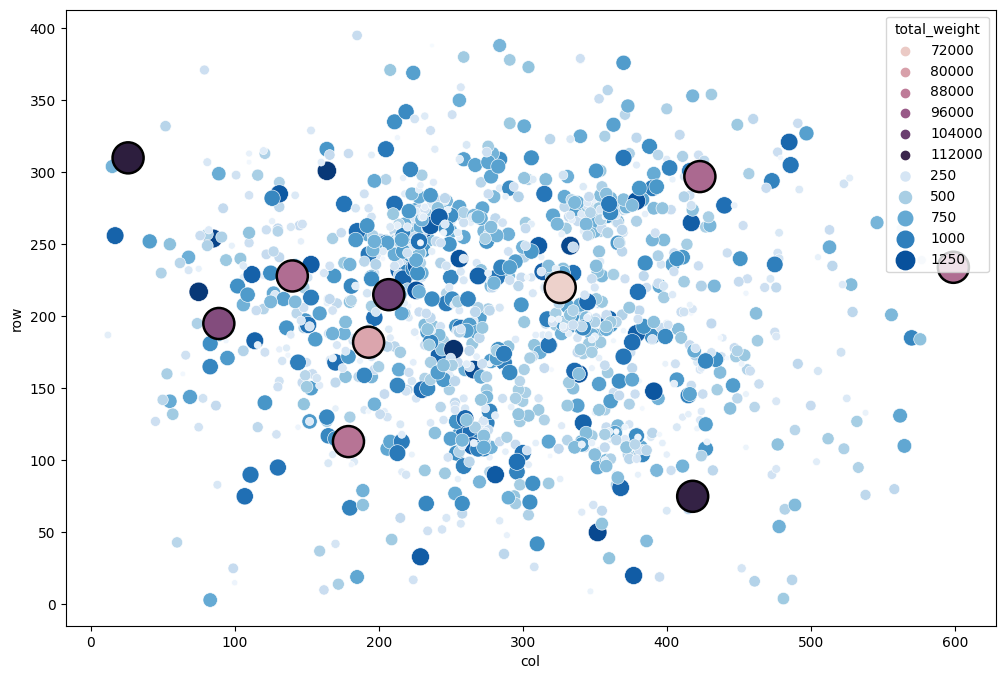

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))

orders_df['total_weight'] = orders_df['ordered_items'].apply(
    lambda x: sum(map(lambda y: product_df.loc[y, 'weight'], x)))
warehouse_total_weight = []
for stock_list in warehouse_df.loc[:, 'stock_list']:
    result = 0
    for idx, stock in enumerate(stock_list):
        result += (product_df.loc[idx, "weight"] * stock)
    warehouse_total_weight.append(result)

warehouse_df['total_weight'] = warehouse_total_weight

sns.scatterplot(data=warehouse_df, x='pos_col', y='pos_row',
                hue='total_weight', ec='black', s=500, ax=ax, zorder=1)

sns.scatterplot(data=orders_df, x='pos_col', y='pos_row',
                hue='total_weight', size='total_weight', sizes=(10, 200),
                ax=ax, zorder=0, palette="Blues")

ax.set_xlabel('col')
ax.set_ylabel('row')
ax.axis('equal')

plt.show()

### Order 별 Weight의 크기와 Warehouse에 있는 stock의 개수


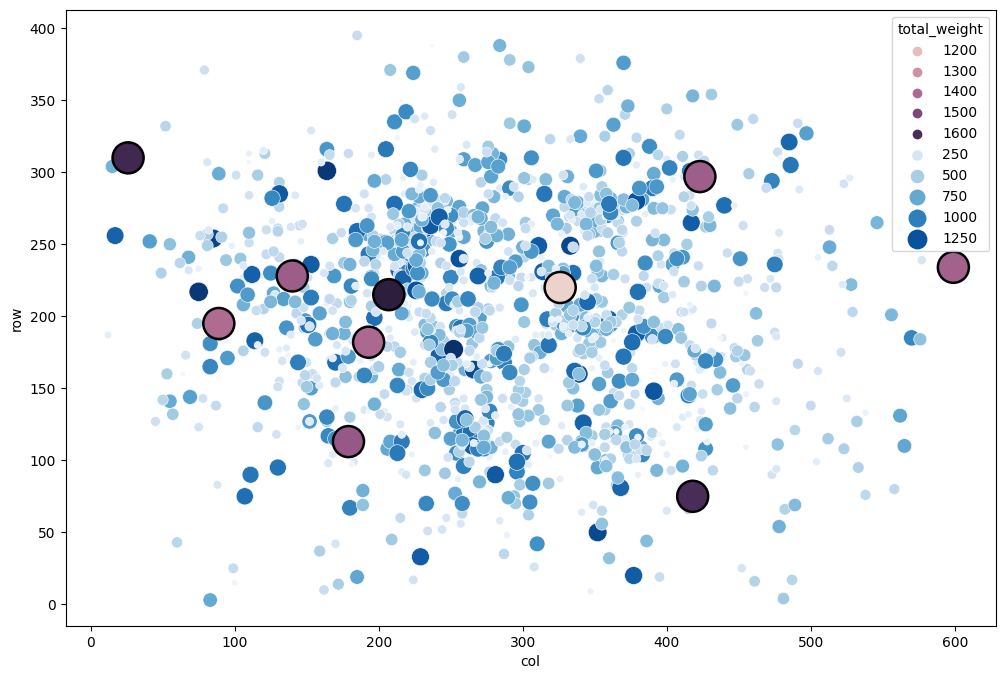

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))

warehouse_df['total_stocks'] = warehouse_df['stock_list'].apply(
    lambda x: sum(x))

sns.scatterplot(data=warehouse_df, x='pos_col', y='pos_row',
                hue='total_stocks', ec='black', s=500, ax=ax, zorder=1)

sns.scatterplot(data=orders_df, x='pos_col', y='pos_row',
                hue='total_weight', size='total_weight', sizes=(10, 200),
                ax=ax, zorder=0, palette="Blues")

ax.set_xlabel('col')
ax.set_ylabel('row')
ax.axis('equal')

plt.show()

### Warehouse_Density


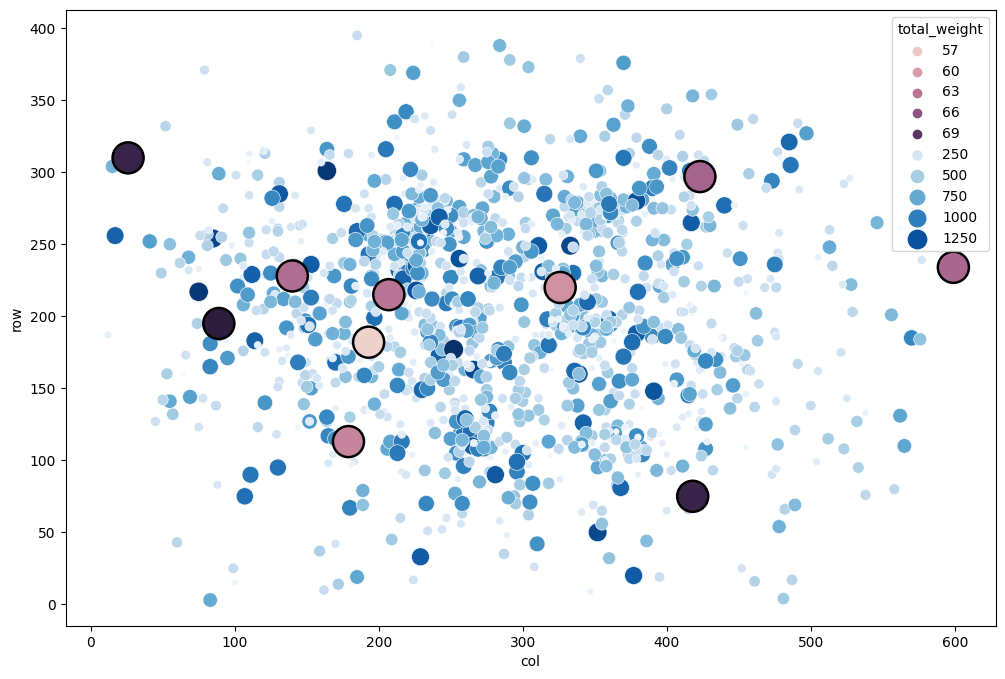

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))

warehouse_df['density'] = warehouse_df['total_weight'] / \
    warehouse_df['total_stocks']

sns.scatterplot(data=warehouse_df, x='pos_col', y='pos_row',
                hue='density', ec='black', s=500, ax=ax, zorder=1)

sns.scatterplot(data=orders_df, x='pos_col', y='pos_row',
                hue='total_weight', size='total_weight', sizes=(10, 200),
                ax=ax, zorder=0, palette="Blues")

ax.set_xlabel('col')
ax.set_ylabel('row')
ax.axis('equal')

plt.show()


## Optimize Product Distribution

### Problem

- 각 주문에 대해, 각 물건을 어떤 창고로부터 가져올 것인가?

### Solution

- 각 물건에 대해 창고를 Source, 주문 위치를 Sink 라고 두고 Min-Cost-Flow 문제를 해결한다.
- 그러면 각 주문에 대해 각 물건이 어떤 source에서 나오는지를 알 수 있다.

### Output

- from_wh_df 라는 3d Numpy 변수에 결과를 담는다.
- from_wh_df[order_id][item_id] = [어디 창고에서 왔는지]
- Ex : from_wh_df[2][6] = [1, 3, -1]

  - 2번 주문에서 6번 물건이 2개 주문되었는데, 각각은 1번, 3번 창고에서 오는 것이 최적화되어 있다.
  - -1은 해당 item 주문이 없음을 의미


In [11]:
max_item_num = max(orders_df.loc[:, "ordered_items"].apply(
    lambda x: max(Counter(x).values())))
from_wh_df = np.full((len(orders_df), len(product_df), max_item_num), -1)
for product in range(len(product_df)):
    # Define Sources (Warehouse)
    sources = warehouse_df.copy()
    sources["stock"] = sources["stock_list"].apply(lambda x: x[product])
    sources = sources[sources["stock"] > 0]

    # Define Sinks (Orders)
    sinks = orders_df[orders_df["ordered_items"].apply(lambda x: product in x)]

    # Initialize Simple Min Cost Flow
    smcf = min_cost_flow.SimpleMinCostFlow()

    # Add All Arcs
    for i in sources.index:
        for j in sinks.index:
            dist = np.ceil(np.sqrt(
                (sources.loc[i, "pos_row"] - sinks.loc[j, "pos_row"]) ** 2 +
                (sources.loc[i, "pos_col"] - sinks.loc[j, "pos_col"]) ** 2
            ))
            capacities = sinks.loc[j, "ordered_items"].count(product)
            smcf.add_arcs_with_capacity_and_unit_cost(
                i, j+WAREHOUSE_LEN, int(capacities), int(dist)
            )
        # Add Overflow Node
        smcf.add_arcs_with_capacity_and_unit_cost(
            i, int(1e4), int(1e4), int(1e4)
        )

    # Add Supplies
    # Supplies
    for i in sources.index:
        smcf.set_nodes_supplies(i, int(sources.loc[i, "stock"]))
    # Demands
    for j in sinks.index:
        smcf.set_nodes_supplies(
            j+WAREHOUSE_LEN, -int(sinks.loc[j, "ordered_items"].count(product)))
    # Overflow Node
    product_sum = sinks.loc[:, "ordered_items"].apply(
        lambda x: x.count(product)).sum()
    stocks_sum = sources.loc[:, "stock"].sum()

    smcf.set_nodes_supplies(
        int(1e4), int(product_sum - stocks_sum)
    )

    if smcf.solve() == smcf.OPTIMAL:
        for arc in range(smcf.num_arcs()):
            if not smcf.flow(arc):
                continue
            if smcf.unit_cost(arc) == int(1e4):
                continue

            this_order = smcf.head(arc) - WAREHOUSE_LEN
            this_wh = int(smcf.tail(arc))
            this_flow = smcf.flow(arc)

            for each_item in range(from_wh_df.shape[-1]):
                if not this_flow:
                    break
                if from_wh_df[this_order, product, each_item] == -1:
                    from_wh_df[this_order, product, each_item] = this_wh
                    this_flow -= 1

    else:
        raise Exception(
            f"product_id {product}: distribution could not be optimized")
from_wh_df[0][6]


array([ 3, -1, -1])

## Give Priority

- Priority는 Batch를 나누어 처리하는 과정에서 영향을 미치게 된다. 상황을 분석하며 최종적으로 어떻게 Priority를 주고 이를 어떻게 적용할지 고찰해보자.

### 평가 지표의 특성 : 작업 순서의 영향을 받음

- 거리가 10인 지점의 주문과 거리가 2인 지점의 주문을 처리하는 경우를 생각해보자.
- turn = 20 이라고 가정하자.
- 어차피 순서에 따른 점수의 유불리를 보고 있으므로 100을 곱하는 과정은 생략하자.
- 이 때 거리가 10인 지점 방문 후 2인 지점을 방문하면
  $$
  \frac {20 - 10} {20} + \frac{20 - 12} {20} = 2 - \frac{10}{20} - \frac{12}{20}
  $$
- 이번엔 거리가 2인 지점 방문 후 10인 지점을 방문하면

  $$
  \frac {20 - 2} {20} + \frac{20 - 12} {20} = 2 - \frac{2}{20} - \frac{12}{20}
  $$

- 즉 평가지표는 합산하는 방식처럼 보이지만, 사실은 총점에서 감점하는 방식을 취하고 있다. 처리해야하는 order의 수 \* 100 이 총점이며 여기에서 걸린 시간이 적을 수록 적게 감점하고 있는 형태인 것이다.
- 위에 비교한 사례처럼 "빨리 끝나는 작업을 먼저 처리해야" 감점되는 양이 훨씬 작다는 것을 알 수 있다.
- 우리가 초반에 설정한 문제 풀이 전략에서 캐글 코드에서는 "단위 작업 경로 설정"과 "드론 배차" 과정에서 우선 순위의 기준을 모두 weight \* distance를 지표로 삼고 있다.
- 그러나, "드론 배차" 과정에서는, 어차피 각각의 "단위 작업 경로"는 MAX_LOAD를 초과하지 않기 때문에 weight는 고려대상이 아니게 된다.
- 따라서 "드론 배차" 과정에서는, weight가 아닌 distance 만을 고려한다. (Batch를 쪼갤 때 영향을 미치게 됨)
- 당연히 총 distance는 작아야 지표가 좋다.
- 그러나 중요한 것은, 짧은 distance가 먼저 처리되는 것도 큰 영향을 미친다는 것이다. 오히려 이것이 총 점수에 더 큰 요인을 미칠 수 있다.

### EDA로 얻은 지도 및 데이터의 특성 분석 : 창고가 수용한 제품의 무게나, 밀도에는 특별한 편향이 보이지는 않으나, 창고 간의 거리가 먼 경우가 있다.

- 일단 위에서 분석한 것으론, 빨리 끝나는 작업을 최대한 빨리 처리하고, 총 distance가 최소화 되는 것이 중요하다.

- 각 Batch를 처리할 때는 최단 distance로 처리하려고 하기 때문에, distance가 작은 루트를 먼저 돈다는 보장이 없다.
- 따라서 distance가 작은 루트를 먼저 처리하게끔 하려면 Batch Size를 줄여서 최대한 거리가 짧은 경로를 먼저 처리하게끔 하여야 한다.
- 그런데 EDA로 분석한 지도를 보면 창고 간의 거리가 매우 큰 경우가 존재한다.
- 데이터의 편향은 없이 모든 창고가 다 비슷한 양의 재고를 가지고 있다. 어떤 order에서 특정 상품이 먼 거리에 있는 warehouse에 있는 위험이 낮다는 것을 알 수 있으며, 특별히 컨트롤 해 줄 수 있는 편향이 없다.
- 각 Batch를 처리할 때에는 CVPR을 통해 최소 distance로 동작하지만, 한 Batch에서 다음 Batch로 넘어갈 때 창고 간 이동이 길어지거나, 놀고 있는 드론이 생길 수 있다.
- Batch Size를 줄이게 되면 Batch가 전환되는 횟수가 늘어나므로 이 요인을 잘 컨트롤 해주어야 한다.

### 요약

1. weight \* distance 지표는 "단위 경로 생성" 과정에서 Batch로 나누어 처리할 때 우선 순위를 가진다.
2. distance 지표는 "드론 배차" 과정에서 Batch로 나누어 처리할 때 우선 순위를 가진다.
3. "드론 배차" 과정의 Batch 값은 크게 설정되어야할 필요가 있다.
4. 단 Batch가 전환되는 순간 창고 간 이동이 길어지거나, 놀고 있는 드론이 생길 수 있으므로 이를 컨트롤 해주어야 한다.
5. 배차 시 distance 지표는 어차피 경로 생성 과정에서 자동으로 얻어지므로, Order 별 Weight \* Distance 값을 확보하여 orders_df에 추가해주면 된다.


In [12]:
weight_dist = np.zeros((len(orders_df)), dtype=int)
accumulated_weight_dist = np.zeros((len(orders_df)), dtype=int)

for wh in warehouse_df.index:
    filtered_index = np.where(from_wh_df == wh)
    weight_this_wh = np.zeros((len(orders_df)), dtype=int)
    for i in range(len(filtered_index[0])):
        weight_this_wh[filtered_index[0][i]
                       ] += product_df.loc[filtered_index[1][i], "weight"]
    weight_dist += np.ceil(np.sqrt(
        (orders_df["pos_row"] - warehouse_df.loc[wh, "pos_row"]) ** 2 +
        (orders_df["pos_col"] - warehouse_df.loc[wh, "pos_col"]) ** 2
    )).astype(int) * weight_this_wh
    orders_df[f"weight_dist_{wh}"] = weight_dist
    accumulated_weight_dist += weight_dist
    weight_dist = np.zeros((len(orders_df)), dtype=int)

orders_df["weight_dist"] = accumulated_weight_dist
orders_df

,pos_row,pos_col,ordered_items,total_weight,weight_dist_0,weight_dist_1,weight_dist_2,weight_dist_3,weight_dist_4,weight_dist_5,weight_dist_6,weight_dist_7,weight_dist_8,weight_dist_9,weight_dist
id,,,,,,,,,,,,,,,
0,340,371,"[226, 183, 6, 220, 299, 280, 12, 42]",419,0,0,0,2691,7353,9321,0,19532,0,15912,54809
1,163,320,[163],45,0,0,0,0,0,5805,0,0,0,0,5805
2,201,331,"[192, 81]",88,0,0,0,0,1760,0,0,0,0,0,1760
3,257,290,"[270, 305, 111, 37, 219, 111, 96, 290, 377, 113]",702,0,0,0,10622,9880,22755,17394,0,0,18904,79555
4,115,512,"[169, 146, 397, 263, 342, 275, 18, 26]",508,0,17316,0,31137,0,0,17819,0,0,24563,90835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,138,331,"[328, 48, 114, 69, 114, 273, 328, 164]",550,0,0,0,0,12782,0,33264,0,0,16192,62238
1246,109,273,"[362, 283, 356, 58, 361, 57, 377, 302]",731,13015,41650,15912,0,0,14824,32631,0,0,10122,128154
1247,161,291,"[348, 364, 293, 260, 200, 288, 43, 384, 32, 6,...",944,10492,0,5535,31400,15042,20503,0,0,29280,0,112252


## Create Delivery Unit Route

### Problem

- WareHouse에서 한 번에 짐을 실어서 배송을 수행하려고 한다.
- 이 때 한 번에 짐을 실어서 배송을 수행하는 것을 하나의 "단위 작업 루트"라고 하자.
- 우리는 이후에 각 드론들에게 단위 작업 루트를 하나씩 부여하는 방식으로 작업을 수행할 것이다.
- 이 때 distance의 총합을 최소화 하는 단위 작업 루트 목록을 구성하시오.
- 현재 각 주문의 각 상품에 대하여 몇 번 Warehouse에서 가져와야 하는지는 결정되어있다.

### Solution

- 각 Order 들에 대해서 CVRP 문제를 푸는데, 최대 가용 Vehicle의 개수를 Order의 개수와 똑같이 맞춘다.
- 이렇게 하면 창고로 되돌아가서 다른 루트로 가는 루트가 생기지 않게 된다.
- 그리고, 이미 어떤 Warehouse에서 어떤 order로 어떤 제품이 가야하는지는 값이 구해져 있으니, 같은 Warehouse에서 처리해야 하는 주문들과 해당 warehouse에 대한 distance metrics를 입력으로 넣는다.
- 이 때 경로 계산 시, 한 번에 모든 계산을 처리하는 방식과 특정 Batch로 나누어서 처리하는 방식이 있다.
- 특정 Batch로 나누어서 처리하면 우선순위가 높은 order들끼리 먼저 최적 경로를 계산한 뒤, 우선 순위가 낮은 order의 최적 경로를 계산한다.
- 그래서 우선 순위가 높은 order를 더 빠르게 처리가 가능하고, 이는 위에 기술한 바와 같이 평가 점수를 올릴 수 있다.

### Output

- routes_df라는 df에 결과를 담는다.
- routes_df에는 시작 warehouse, 해당 route의 command, 종점의 위치, 경로의 거리를 담는다.


In [13]:
def get_distance_matrix(mode, path=None):
    if mode == "LOAD":
        return pd.read_pickle(path)
    elif mode == "CREATE":
        routes_df = pd.DataFrame()

        distance_matrix = np.zeros(
            (len(orders_df) + 10, len(orders_df) + 10), dtype=int)

        for i in orders_df.index:
            for j in orders_df.index:
                distance_matrix[i][j] = np.ceil(np.sqrt(
                    (orders_df.loc[i, "pos_row"] -
                     orders_df.loc[j, "pos_row"]) ** 2 +
                    (orders_df.loc[i, "pos_col"] -
                     orders_df.loc[j, "pos_col"]) ** 2
                )).astype(int)
                distance_matrix[j][i] = distance_matrix[i][j]
        INF = int(1e7)
        for wh in warehouse_df.index:
            wh_row = warehouse_df.loc[wh, "pos_row"]
            wh_col = warehouse_df.loc[wh, "pos_col"]
            for order in orders_df.index:
                distance_matrix[len(orders_df) + wh][order] = np.ceil(np.sqrt(
                    (wh_row - orders_df.loc[order, "pos_row"]) ** 2 +
                    (wh_col - orders_df.loc[order, "pos_col"]) ** 2
                )).astype(int)
                distance_matrix[order][len(orders_df) + wh] = INF

        for wh_i in warehouse_df.index:
            for wh_j in warehouse_df.index:
                if wh_i == wh_j:
                    continue
                distance_matrix[len(orders_df) +
                                wh_i][len(orders_df)+wh_j] = INF
        with open(path, 'wb') as f:
            pickle.dump(distance_matrix, f)
        return distance_matrix


get_distance_matrix(mode="LOAD", path="./distance_matrix.pkl")

array([[       0,      185,      145, ..., 10000000, 10000000, 10000000],
       [     185,        0,       40, ..., 10000000, 10000000, 10000000],
       [     145,       40,        0, ..., 10000000, 10000000, 10000000],
       ...,
       [     257,      192,      193, ...,        0, 10000000, 10000000],
       [     347,      329,      324, ..., 10000000,        0, 10000000],
       [      68,      170,      133, ..., 10000000, 10000000,        0]])

In [14]:
distance_matrix = get_distance_matrix(
    mode="LOAD", path="./distance_matrix.pkl")
print(distance_matrix)
print(distance_matrix[-10][390])


[[       0      185      145 ... 10000000 10000000 10000000]
 [     185        0       40 ... 10000000 10000000 10000000]
 [     145       40        0 ... 10000000 10000000 10000000]
 ...
 [     257      192      193 ...        0 10000000 10000000]
 [     347      329      324 ... 10000000        0 10000000]
 [      68      170      133 ... 10000000 10000000        0]]
15


In [23]:
def get_route_df(mode, batch=1, path=None):
    if mode == "LOAD":
        return pd.read_pickle(path)
    elif mode == "CREATE":
        route_df = pd.DataFrame(
            columns=["wh_id", "route", "end_order", "distance"])
        for wh in warehouse_df.index:
            print(f"wh_id {wh} is processing...")
            idx = list(np.where(from_wh_df == wh))
            idx_mapping = {i: item for i, item in enumerate(
                zip(idx[0], idx[1], idx[2]))}
            priority_df = orders_df.loc[idx[0], :]
            priority_df["index"] = [i for i in range(len(idx[0]))]

            priority_df = priority_df.sort_values(
                by=f"weight_dist_{wh}")

            for i in range(len(idx[0])):
                idx[0][i] = idx_mapping[priority_df.iloc[i]["index"]][0]
                idx[1][i] = idx_mapping[priority_df.iloc[i]["index"]][1]
                idx[2][i] = idx_mapping[priority_df.iloc[i]["index"]][2]

            batch_split = np.linspace(0, len(idx[0]), batch+1, dtype=int)

            for batch_idx in tqdm(range(batch), desc=f"batch progress"):
                batch_order_idx = idx[0][batch_split[batch_idx]:
                                         batch_split[batch_idx+1]]
                batch_product_idx = idx[1][batch_split[batch_idx]:
                                           batch_split[batch_idx+1]]
                batch_item_idx = idx[2][batch_split[batch_idx]:
                                        batch_split[batch_idx+1]]
                # Get wh_distance_matrix
                wh_distance_matrix = distance_matrix.copy()
                wh_distance_matrix[:len(orders_df), len(orders_df) + wh] = 0
                wh_distance_matrix = wh_distance_matrix[np.ix_(
                    np.append(batch_order_idx, len(orders_df) + wh),
                    np.append(batch_order_idx, len(orders_df) + wh))]

                # Get wh_demand_info
                mapper = {node: idx for node, idx in enumerate(
                    zip(batch_order_idx, batch_product_idx, batch_item_idx))}
                wh_demand_info = np.zeros(
                    (max(batch_order_idx) + 1, max(batch_product_idx) + 1, max(batch_item_idx + 1)), dtype=int)
                for order, product, item in zip(batch_order_idx, batch_product_idx, batch_item_idx):
                    wh_demand_info[order][product][item] = product_df.loc[product, "weight"]

                # Make Routing Model
                manager = pywrapcp.RoutingIndexManager(
                    len(wh_distance_matrix),
                    len(batch_order_idx),
                    len(wh_distance_matrix) - 1
                )

                routing = pywrapcp.RoutingModel(manager)

                def distance_callback(from_index, to_index):
                    from_node = manager.IndexToNode(from_index)
                    to_node = manager.IndexToNode(to_index)
                    # print("calling")
                    return wh_distance_matrix[from_node][to_node]

                transit_callback_index = routing.RegisterTransitCallback(
                    distance_callback)
                routing.SetArcCostEvaluatorOfAllVehicles(
                    transit_callback_index)

                def demand_callback(from_index):
                    from_node = manager.IndexToNode(from_index)
                    if from_node == len(batch_order_idx):
                        return 0
                    else:
                        idx_tuple = mapper[from_node]
                        return wh_demand_info[idx_tuple[0]][idx_tuple[1]][idx_tuple[2]]
                        # return 200

                demand_callback_index = routing.RegisterUnaryTransitCallback(
                    demand_callback
                )
                routing.AddDimensionWithVehicleCapacity(
                    demand_callback_index,
                    0,
                    [PAYLOAD] * len(batch_order_idx),
                    True,
                    "Capacity"
                )

                search_parameters = pywrapcp.DefaultRoutingSearchParameters()
                search_parameters.first_solution_strategy = (
                    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

                solution = routing.SolveWithParameters(search_parameters)

                if solution:
                    for vehicle_id in range(len(batch_order_idx)):
                        index = routing.Start(vehicle_id)
                        route_distance = 0
                        route = []
                        while not routing.IsEnd(index):
                            node_index = manager.IndexToNode(index)
                            route.append(node_index)
                            previous_index = index
                            index = solution.Value(
                                routing.NextVar(index))
                            route_distance += routing.GetArcCostForVehicle(
                                previous_index, index, vehicle_id)
                        route.append(manager.IndexToNode(index))
                        if not route_distance:
                            continue
                        route = [mapper[x]
                                 for x in route if x != len(wh_distance_matrix) - 1]
                        route_df = pd.concat([route_df,
                                              pd.DataFrame({"wh_id": wh,
                                                            "route": [route],
                                                            "end_order": [route[-1]],
                                                            "distance": route_distance})],
                                             ignore_index=True
                                             )
                else:
                    raise Exception(
                        f"wh_id {wh}: routing could not be optimized")

        route_df.to_pickle(path)
        display(route_df)
        return route_df


route_df = get_route_df(mode="CREATE", batch=8, path="./route_df.pkl")


wh_id 0 is processing...


batch progress:   0%|          | 0/8 [00:00<?, ?it/s]